# PDR: Stride length estimation

In [1]:
import sys
import os

PROJECT_HOME = "./../.."
# Add utilities library for Microsoft Indoor Localization 2.0 Dataset
INDOOR_COMPETITION_20_DIR = os.path.join(PROJECT_HOME, "code",
                                         "indoor-location-competition-20")
print("The library is located at", INDOOR_COMPETITION_20_DIR)
sys.path.append(INDOOR_COMPETITION_20_DIR)

CODE_DIR = os.path.join(PROJECT_HOME, "code")
print(f"The code is located in {CODE_DIR}")
sys.path.append(CODE_DIR)

The library is located at ./../../code/indoor-location-competition-20
The code is located in ./../../code


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from io_f import read_data_file
from py_indoor_loc.floor_map import read_floor_data, extract_floor_map_geometries, scale
from py_indoor_loc.zee import create_search_grid, SearchGrid
from shapely import ops as shapely_ops
from shapely import vectorized as shapely_vectorized
from shapely.geometry import LineString
from compute_f import compute_step_heading
from compute_f import compute_rel_positions
from compute_f import correct_positions
from scipy.interpolate import interp1d
from dataclasses import dataclass


from py_indoor_loc.plot import plot_floor_map, plot_waypoint_location
from py_indoor_loc.sensors import estimate_acceleration_heading
from py_indoor_loc.pdr.step_detection import compute_mean, compute_local_acc_variance, compute_step_positions

In [3]:
from scipy import signal

## Reading Data

* Reading Track Data

In [4]:
TRAIN_DATA_DIR = "../../data/train/"

In [5]:
site_id, floor_id = "5cd56b6ae2acfd2d33b59ccb", "F2"

In [6]:
data_files = glob(f"{TRAIN_DATA_DIR}{site_id}/{floor_id}/*.txt")

* Reading floor map data

In [7]:
floor_info, floor_map = read_floor_data(
  f"../../data/metadata/{site_id}/{floor_id}")

transform_func = lambda coords: coords

(
  floor_polygons,
  store_polygons,
  x_min,
  y_min,
  x_max,
  y_max,
  width_meter,
  height_meter,
) = extract_floor_map_geometries(floor_map, floor_info, transform=transform_func)


In [8]:
path_datas = read_data_file(data_files[10])

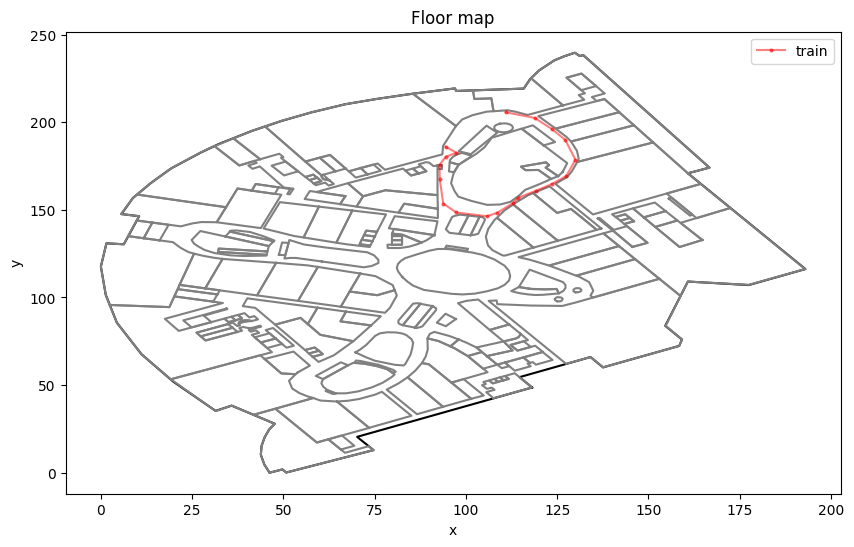

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

plot_floor_map(floor_polygons, store_polygons, ax=ax)

waypoint_location = transform_func(path_datas.waypoint[:, 1:])
ax.plot(waypoint_location[:, 0],
        waypoint_location[:, 1],
        marker="o",
        markersize=2,
        color="red",
        label="train",
        alpha=0.5)
ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

In [10]:
def plot_line_with_directions(xy: np.ndarray, ax: plt.Axes | None, 
                              arrow_scale: float = 0.5) -> plt.Axes:
  if ax is None:
    _, ax = plt.subplots()

  # Sample data: array of (x, y) coordinates
  x, y = xy[:, 0], xy[:, 1]

  # Compute direction vectors (u, v) along the line segments
  dx = np.diff(x)  # Differences in x-coordinates
  dy = np.diff(y)  # Differences in y-coordinates
  directions = np.arctan2(dy, dx)  # Calculate the direction angle in radians
  direction_length = np.sqrt(dx * dx + dy * dy)

  # Plot the line
  ax.plot(x, y, '--o', label='Line')

  # Plot arrows along the line using quiver
  ax.quiver(x[:-1],
            y[:-1],
            arrow_scale * direction_length * np.cos(directions),
            arrow_scale * direction_length * np.sin(directions),
            angles='xy',
            scale_units='xy',
            scale=1,
            color='blue',
            label='Direction',
            linewidth=0.2,
            ls="--")

  return ax

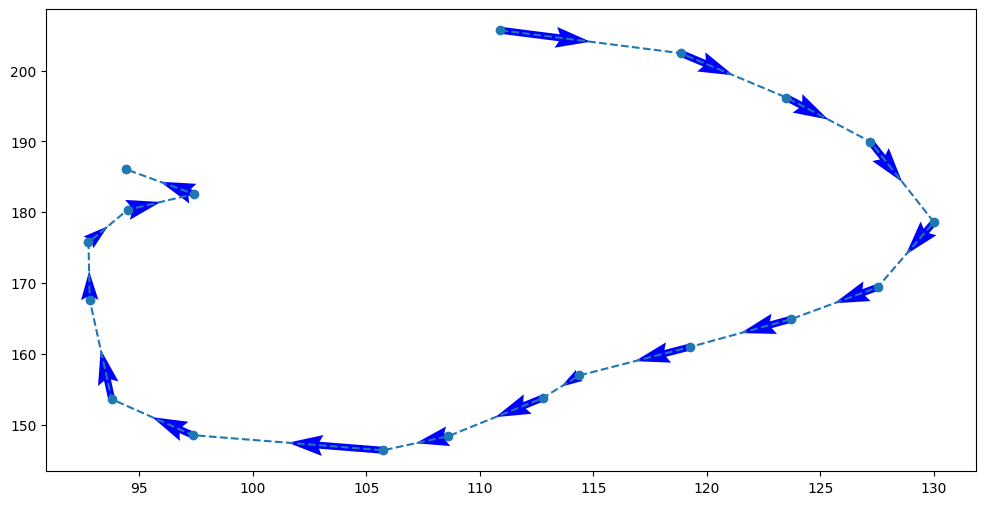

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

plot_line_with_directions(path_datas.waypoint[:, 1:], ax=ax, arrow_scale=.5)

plt.show()

In [12]:
acce, heading = estimate_acceleration_heading(acce=path_datas.acce, magn=path_datas.magn)

In [13]:
acce_magnitude = np.linalg.norm(acce, axis=1)

In [14]:
def filter_lp(acce_magnitude: np.ndarray,
              cutoff_frequency: int = 3,
              filter_order: int = 4,
              fs: int = 50) -> np.ndarray:

  b, a = signal.butter(filter_order,
                       cutoff_frequency,
                       'low',
                       analog=False,
                       fs=fs)
  # Apply the filter to the noisy signal
  f_acce_magnitude = signal.filtfilt(b, a, acce_magnitude)

  return f_acce_magnitude

In [15]:
lp_acce_magnitude = filter_lp(acce_magnitude, cutoff_frequency=3, filter_order=4, fs=50)

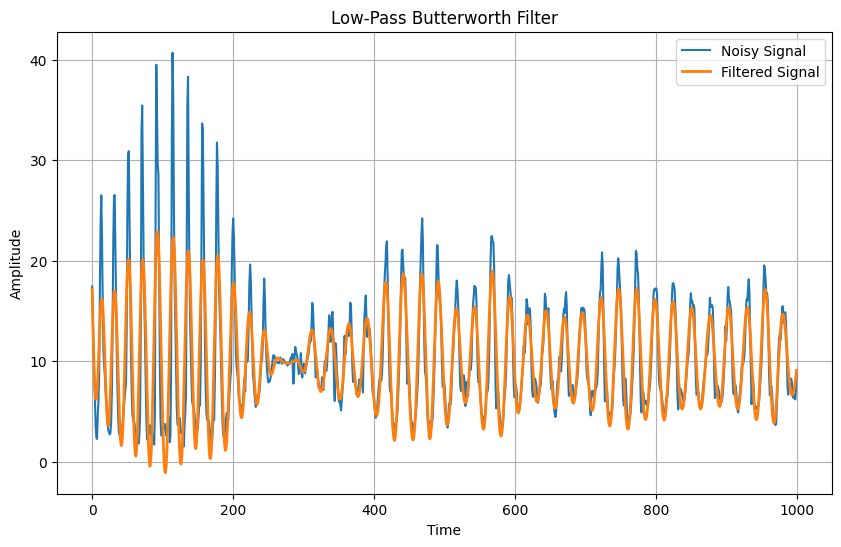

In [16]:
acce_m_ = acce_magnitude[:1000]
lp_acce_m_ = filter_lp(acce_m_)

# Plot the original noisy signal and the filtered signal
plt.figure(figsize=(10, 6))
plt.plot(range(len(acce_m_)), acce_m_, label='Noisy Signal')
plt.plot(range(len(acce_m_)), lp_acce_m_, label='Filtered Signal', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.title('Low-Pass Butterworth Filter')
plt.show()


In [17]:
def filter_lp(acce_magnitude: np.ndarray,
              cutoff_frequency: int = 3,
              filter_order: int = 4,
              fs: int = 50) -> np.ndarray:

  b, a = signal.butter(filter_order,
                       cutoff_frequency,
                       'low',
                       analog=False,
                       fs=fs)
  # Apply the filter to the noisy signal
  f_acce_magnitude = signal.filtfilt(b, a, acce_magnitude)

  return f_acce_magnitude

In [18]:
def compute_stride_length_weinberg(acce_magnitude: np.ndarray,
                                   lp_params: dict | None = None,
                                   K: float = 1.0,
                                   w: int = 15):
  if lp_params is None:
    lp_params = {
        "cutoff_frequency": 3,
        "filter_order": 4,
        "fs": 50,
    }

  n = len(acce_magnitude)
  f_acce_magnitude = filter_lp(acce_magnitude, **lp_params)

  sl = np.zeros(n, dtype=np.float32)

  for k in range(0, n):
    j_min, j_max = max(0, k - w), min(n - 1, k + w)
    sl[k] = K * np.power(
        f_acce_magnitude[j_min:j_max + 1].max() -
        f_acce_magnitude[j_min:j_max + 1].min(), 0.25)

  return sl

* Pipe it to a method

In [97]:
from scipy.ndimage import median_filter

In [19]:
def create_sensor_df(read_data) -> pd.DataFrame:
  magn_df = pd.DataFrame(read_data.magn,
                         columns=["ts", "magn_x", "magn_y", "magn_z"])
  acce_df = pd.DataFrame(read_data.acce,
                         columns=["ts", "acce_x", "acce_y", "acce_z"])
  ahrs_df = pd.DataFrame(read_data.ahrs,
                         columns=["ts", "ahrs_x", "ahrs_y", "ahrs_z"])
  
  sensor_df = pd.merge(acce_df, magn_df, on="ts", how="outer")
  sensor_df.ffill(inplace=True)

  sensor_df = pd.merge(sensor_df, ahrs_df, on="ts", how="outer")
  sensor_df.ffill(inplace=True)

  sensor_df["ts"] = sensor_df["ts"].astype(np.int64)
  sensor_df.sort_values("ts", ascending=True, inplace=True)
  return sensor_df

In [42]:
sensor_df = create_sensor_df(path_datas)
acce, heading = estimate_acceleration_heading(
    acce=sensor_df[["ts", "acce_x", "acce_y", "acce_z"]].values,
    magn=sensor_df[["ts", "magn_x", "magn_y", "magn_z"]].values)
acce_magnitudes = np.linalg.norm(acce, axis=1)


In [51]:
def compute_local_acc_variance(acce: np.ndarray, window_size: int = 15):
  """
  Compute the local acceleration variance to highlight the foot activity and to remove gravity.
  """
  n = len(acce)
  variance = np.zeros_like(acce, dtype=np.float32)
  for i in range(n):
    start_idx = max(0, i - window_size)
    end_idx = min(n, i + window_size + 1)
    variance[i] = np.var(acce[start_idx:end_idx])

  return np.sqrt(variance)

In [75]:
def compute_step_positions(acce_var: np.ndarray,
                           swing_threshold: float = 2,
                           stance_threshold: float = 1,
                           window_size: int = 15):
  n = len(acce_var)
  steps = np.array([False] * n)

  # swing[i] = T1 if var > T1, 0 otherwise
  swing = np.zeros(n, dtype=np.float32)
  swing[acce_var > swing_threshold] = swing_threshold

  # stance[i] = T2 if var < T2, 0 otherwise
  stance = np.zeros(n, dtype=np.float32)
  stance[acce_var < stance_threshold] = stance_threshold

  for i in range(1, n):
    if (swing[i - 1] > swing[i]) and np.max(
        stance[i:min(i + window_size, n)]) == stance_threshold:
      steps[i] = True

  return steps, swing, stance


In [98]:
f_acce_m = median_filter(acce_magnitudes, size=9)

In [134]:
window_size = 4
acce_mean = compute_mean(f_acce_m, window_size=window_size)
acce_var = compute_local_acc_variance(f_acce_m, window_size=window_size)
step_mask, swing, stance = compute_step_positions(acce_var,
                                                  swing_threshold=2,
                                                  stance_threshold=1,
                                                  window_size=window_size)

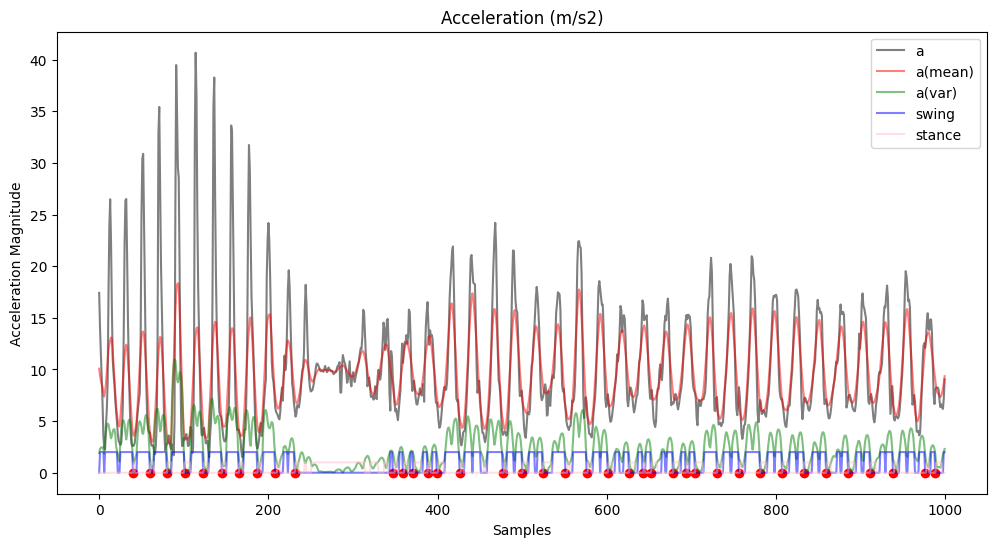

In [135]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

n_samples = 1000
ax.plot(acce_magnitudes[:n_samples], alpha=0.5, label="a", color="black")
ax.plot(acce_mean[:n_samples], alpha=0.5, label="a(mean)", color="red")
ax.plot(acce_var[:n_samples], alpha=0.5, label="a(var)", color="green")
ax.plot(swing[:n_samples], alpha=0.5, label="swing", color="blue")
ax.plot(stance[:n_samples], alpha=0.5, label="stance", color="pink")

for i in range(n_samples):
  if step_mask[i]:
    ax.scatter(i, 0, marker="o", color="red")

ax.set_title("Acceleration (m/s2)")
ax.set_xlabel("Samples")
ax.set_ylabel("Acceleration Magnitude")
ax.legend()

plt.show()

In [142]:
sl = compute_stride_length_weinberg(acce_magnitudes, w=4, K=0.364)
sensor_timestamps = sensor_df["ts"].values
heading_with_timestamps = np.vstack((sensor_timestamps, heading)).T
step_timestamps = sensor_timestamps[step_mask]
step_headings = compute_step_heading(step_timestamps, heading_with_timestamps)
step_headings[:, 1] = np.radians(step_headings[:, 1])
stride_lengths = np.zeros((len(step_timestamps), 2), dtype=np.float64)
stride_lengths[:, 0] = step_timestamps
stride_lengths[:, 1] = sl[step_mask]
rel_positions = compute_rel_positions(stride_lengths, step_headings)

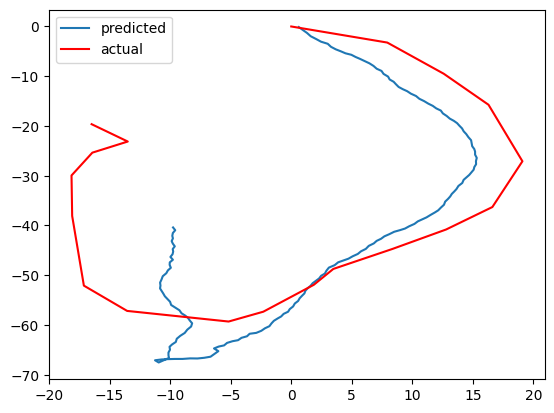

In [143]:
fig, ax = plt.subplots()

cx = np.cumsum(rel_positions[:, 1])
cy = np.cumsum(rel_positions[:, 2])

ax.plot(cx, cy, label="predicted")
ax.plot(path_datas.waypoint[:, 1] - path_datas.waypoint[0, 1], 
        path_datas.waypoint[:, 2] - path_datas.waypoint[0, 2], 
        color="red", label="actual")
ax.legend()

plt.show()

## ZUPT SL Algorithm

In [107]:
def integrate(a: np.ndarray, fs: int = 50) -> np.ndarray:
  n = len(a)
  prev_v = 0
  result = np.zeros(n, dtype=np.float32)
  for i in range(n):
    result[i] = prev_v + a[i] / fs
    prev_v = result[i]
  return result

In [108]:
fs = 50

In [109]:
window_size = 25

In [110]:
vx = integrate(acce[:, 0], fs=50)
vy = integrate(acce[:, 1], fs=50)
vz = integrate(acce[:, 2], fs=50)

In [111]:
cvx = np.zeros_like(vx)
cvy = np.zeros_like(vy)
cvz = np.zeros_like(vz)

In [119]:
step_indices = np.where(step_mask)[0]
n = len(acce)

In [120]:
prev_ik = 0

prev_mu = (0, 0, 0)

for ik in step_indices:

  min_ik, max_ik = max(0, ik - window_size), min(n, ik + window_size)
  mu_k_x = np.mean(vx[min_ik:max_ik + 1])
  mu_k_y = np.mean(vy[min_ik:max_ik + 1])
  mu_k_z = np.mean(vz[min_ik:max_ik + 1])

  n_samples = ik - prev_ik
  pmk_x, pmk_y, pmk_z = prev_mu

  for i in range(prev_ik, ik):
    cvx[i] = vx[i] - (pmk_x * (ik - i) + mu_k_x * (i - prev_ik)) / n_samples
    cvy[i] = vy[i] - (pmk_y * (ik - i) + mu_k_y * (i - prev_ik)) / n_samples
    cvz[i] = vz[i] - (pmk_z * (ik - i) + mu_k_z * (i - prev_ik)) / n_samples

  prev_ik = ik
  prev_mu = (mu_k_x, mu_k_y, mu_k_z)

In [121]:
prev_ik = 0

delta_pk = []

for ik in step_indices:
  delta_pk_x = cvx[prev_ik:ik].sum() / fs
  delta_pk_y = cvy[prev_ik:ik].sum() / fs
  delta_pk_z = cvz[prev_ik:ik].sum() / fs

  delta_pk.append((delta_pk_x, delta_pk_y, delta_pk_z))
  

In [122]:
sl_zupt = np.sqrt([pkn * pkn + pke * pke for (pkn, pke, _) in delta_pk])

In [123]:
sensor_timestamps = sensor_df["ts"].values
heading_with_timestamps = np.vstack((sensor_timestamps, heading)).T
step_timestamps = sensor_timestamps[step_mask]
step_headings = compute_step_heading(step_timestamps, heading_with_timestamps)
step_headings[:, 1] = np.radians(step_headings[:, 1])
stride_lengths = np.zeros((len(step_timestamps), 2), dtype=np.float64)
stride_lengths[:, 0] = step_timestamps
stride_lengths[:, 1] = sl_zupt
rel_positions = compute_rel_positions(stride_lengths, step_headings)
step_locations = correct_positions(rel_positions, path_datas.waypoint)

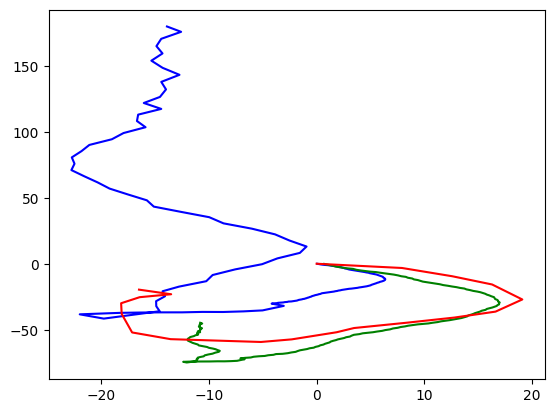

In [128]:
fig, ax = plt.subplots()

crpx = np.cumsum(rel_positions[:, 1])
crpy = np.cumsum(rel_positions[:, 2])

ax.plot(crpx, crpy, color="blue")
ax.plot(cx, cy, color="green")
ax.plot(path_datas.waypoint[:, 1] - path_datas.waypoint[0, 1], 
        path_datas.waypoint[:, 2] - path_datas.waypoint[0, 2], 
        color="red")

plt.show()

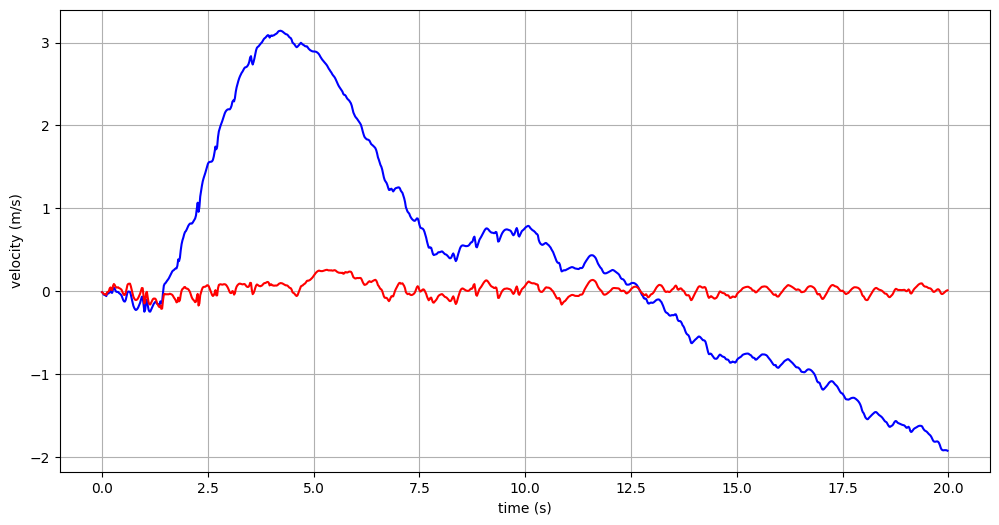

In [131]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

n_samples = 1000
ts = np.arange(n_samples) / 50

ax.plot(ts, vx[:n_samples], color="blue", label="actual")
ax.plot(ts, cvx[:n_samples], color="red", label="corrected")

ax.grid()

ax.set_xlabel("time (s)")
ax.set_ylabel("velocity (m/s)")


# ax.plot(ts, vx[:n_samples], color="blue")
# ax.plot(ts, vy[:n_samples])
# ax.plot(ts, cvy[:n_samples])

# ax.plot(ts, vz[:n_samples])
# ax.plot(ts, cvz[:n_samples])

plt.show()

## Step Detection using Gyroscopes

In [137]:
from scipy.ndimage import median_filter

In [ ]:
class GyroStepDetector(object):
  def __init__(self, threshold: float)

In [ ]:
path_datas.gyro

In [176]:
window_size = 5
total_angular_velocity = np.linalg.norm(path_datas.gyro[:, 1:], axis=1)

f_total_angular_velocity = median_filter(total_angular_velocity, size=window_size)

In [177]:
n = len(f_total_angular_velocity)
step_mask = np.ones(n, dtype=np.uint8)
step_mask[f_total_angular_velocity <= 1.0] = 0
step_indices = np.where(step_mask[1:] > step_mask[:-1])[0]
step_mask = np.array([False] * n)
step_mask[step_indices] = True

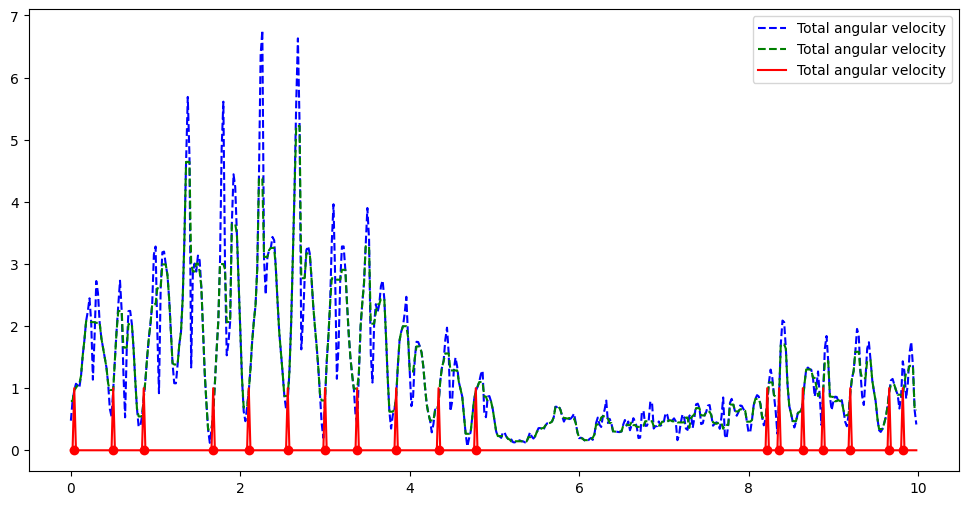

In [178]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ts = np.arange(n) / 50
n_samples = 500
ax.plot(ts[:n_samples], total_angular_velocity[:n_samples], ls="--", color="blue", label="Total angular velocity")
ax.plot(ts[:n_samples], f_total_angular_velocity[:n_samples], ls="--", color="green", label="Total angular velocity")
ax.plot(ts[:n_samples], step_mask[:n_samples], label="Total angular velocity", color="red")

for step_idx in step_indices:
  if step_idx < n_samples:
    ax.scatter(step_idx / 50, 0, marker="o", color="red")

ax.legend()

plt.show()

In [179]:
sl = compute_stride_length_weinberg(acce_magnitudes, w=8, K=0.364)
sensor_timestamps = sensor_df["ts"].values
heading_with_timestamps = np.vstack((sensor_timestamps, heading)).T
step_timestamps = sensor_timestamps[step_mask]
step_headings = compute_step_heading(step_timestamps, heading_with_timestamps)
step_headings[:, 1] = np.radians(step_headings[:, 1])
stride_lengths = np.zeros((len(step_timestamps), 2), dtype=np.float64)
stride_lengths[:, 0] = step_timestamps
stride_lengths[:, 1] = sl[step_mask]
rel_positions = compute_rel_positions(stride_lengths, step_headings)

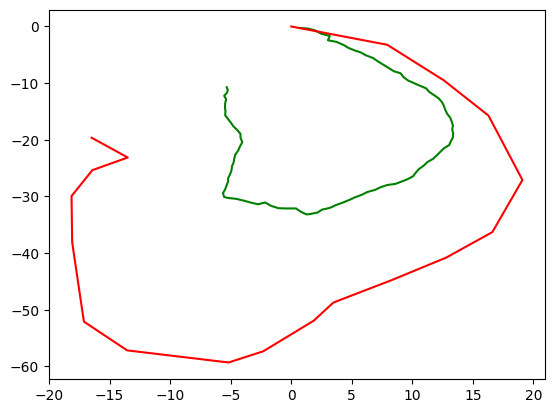

In [180]:
fig, ax = plt.subplots()

cx = np.cumsum(rel_positions[:, 1])
cy = np.cumsum(rel_positions[:, 2])

ax.plot(cx, cy, color="green")
ax.plot(path_datas.waypoint[:, 1] - path_datas.waypoint[0, 1], 
        path_datas.waypoint[:, 2] - path_datas.waypoint[0, 2], 
        color="red")

plt.show()

## Pitch-based Step Detection

In [ ]:
# TODO